# Lesson 6: Reward hacking

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code>  file:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

Start by importing dependencies and setting up two clients, one for OpenAI and one for Predibase:

In [8]:
import os
from datasets import load_dataset
from dotenv import load_dotenv
from openai import OpenAI

from utils import *

load_dotenv()

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

pb_client = OpenAI(
    base_url=os.environ["PREDIBASE_MODEL_LLAMA_URL"],
    api_key=os.environ["PREDIBASE_API_KEY"],
)

## Hacking the summarization task with longer summaries

Here, you'll see how longer summaries could lead to higher rewards. Start by loading the same earnings call dataset from the previous lesson:

In [20]:
ds = load_dataset("mrSoul7766/ECTSum")
transcript = ds["train"][1]["text"]

Generate a quiz based on the call:

In [21]:
quiz = generate_quiz(transcript)
print(quiz)


Question 1:
By what percent did comparable store sales grow in Q1?
A. 24.7%
B. 32.1%
C. 29.4%
D. 15.4%

Question 2:
What percentage did adjusted SG&A expenses represent of net sales?
A. 36.4%
B. 38.5%
C. 35.8%
D. 34.5%

Question 3:
How much did the company return to shareholders through share repurchases and dividends?
A. $203 million
B. $200 million
C. $300 million
D. $400 million

Question 4:
What was the adjusted gross profit margin for Q1?
A. 44.8%
B. 43.7%
C. 42.5%
D. 45.5%


Generate 8 summaries of the call (again, you'll use the Llama-3.1-8B-Instruct-dequantized, which is defined in the utils.py file):

In [22]:
prompt = f"""Generate a concise bulleted summary of the 
information in the following earnings call transcript.

Only respond with the summary, do not include any extraneous text.

Transcript:

{transcript}
"""

completions = pb_client.chat.completions.create(
    model=MODEL_NAME,
    messages=[
        {"role": "user", "content": prompt},
    ],
    n=8,
    temperature=0.9,
)

Use each summary to take the quiz and get a reward score:

In [23]:
responses = [choice.message.content for choice in completions.choices]
quiz_rewards = [quiz_reward(resp, quiz) for resp in responses]
quiz_rewards

[0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75]

The transcript should get a perfect score: check that it does:

In [24]:
transcript_score = quiz_reward(transcript, quiz)
transcript_score

1.0

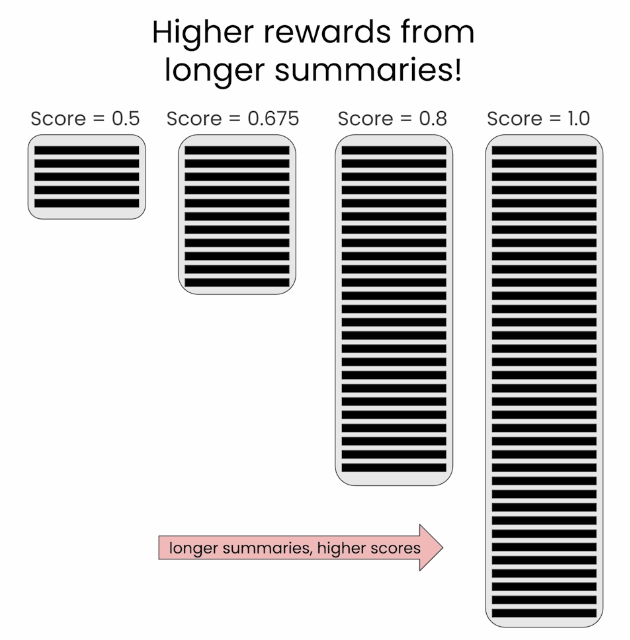

- Over time, we might expect that the model will actually learn to game the system or hack its way to a better score by ignoring the objective of being concise that's in the prompt, and instead just optimizing for the reward by just returning exactly what was in the transcript.
- How might we think about mitigating this? Put in a new reward function that accounts for the conciseness attribute that we care about such as th elenghts of the different completion or create a penalty function to discourage longer summaries

Check lengths of the 8 summaries and compare to full transcript:

In [25]:
lengths = [len(resp) for resp in responses]
lengths

[1038, 1180, 1023, 1174, 1167, 1064, 1172, 1130]

In [26]:
len(transcript)

21810

## Create a penalty function to discourage longer summaries

Here, you'll create a reward function that assigns a negative score (i.e. a penalty) to the model for longer summaries. Over time during training, this penalty should discourage the model from getting higher quiz scores just by writing longer summaries.

In [27]:
def length_penalty_reward(response: str) -> float:
    length = len(response)
    target_length = 1024 #reasonable  max length
    if length <= target_length:
        return 0.0
    else:#Linearly decrease reward as length increases beyond max
        return max(
            (target_length - length) / target_length,
            -10
        ) 

In [28]:
transcript_reward = length_penalty_reward(transcript)
transcript_reward

-10

Show the length penalties and resulting advantages for the 8 summaries:

In [29]:
lengths = [len(resp) for resp in responses]
length_rewards = [
    length_penalty_reward(resp) for resp in responses
]
print_length_table(lengths, length_rewards)

+---------+----------+------------+-------------+
|   Index |   Length |     Reward |   Advantage |
+=========+==========+============+=============+
|       0 |     1038 | -0.0136719 |    1.30384  |
+---------+----------+------------+-------------+
|       1 |     1180 | -0.152344  |   -0.992539 |
+---------+----------+------------+-------------+
|       2 |     1023 |  0         |    1.53025  |
+---------+----------+------------+-------------+
|       3 |     1174 | -0.146484  |   -0.895509 |
+---------+----------+------------+-------------+
|       4 |     1167 | -0.139648  |   -0.782307 |
+---------+----------+------------+-------------+
|       5 |     1064 | -0.0390625 |    0.88338  |
+---------+----------+------------+-------------+
|       6 |     1172 | -0.144531  |   -0.863165 |
+---------+----------+------------+-------------+
|       7 |     1130 | -0.103516  |   -0.183953 |
+---------+----------+------------+-------------+


Add the length penalty to the quiz reward score:

In [30]:
def total_reward(length_reward, quiz_reward):
    return length_reward + quiz_reward

In [31]:
total_rewards = [
    total_reward(length_reward, quiz_reward) 
    for length_reward, quiz_reward
    in zip(length_rewards, quiz_rewards)
]

In [33]:
total_rewards

[0.736328125,
 0.59765625,
 0.75,
 0.603515625,
 0.3603515625,
 0.7109375,
 0.10546875,
 0.646484375]

Visualize the trade-off between length and quiz score in determining advantages:

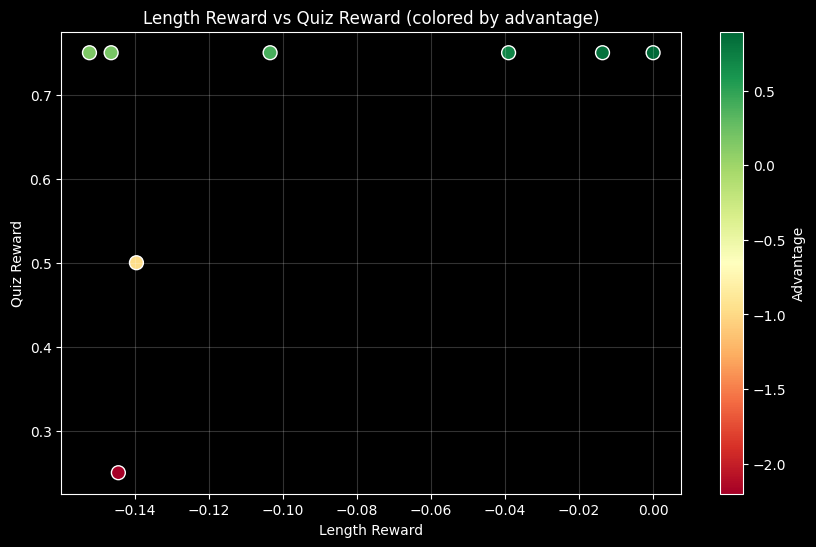

In [32]:
from matplotlib import pyplot as plt

advantages = compute_advantages(total_rewards)
min_adv = min(advantages)
max_adv = max(advantages)

plt.figure(figsize=(10,6), facecolor='black')
plt.style.use('dark_background')
scatter = plt.scatter(length_rewards, quiz_rewards, c=advantages, cmap='RdYlGn', s=100, edgecolor='white', vmin=min_adv, vmax=max_adv)
plt.colorbar(scatter, label='Advantage')
plt.xlabel('Length Reward')
plt.ylabel('Quiz Reward')
plt.title('Length Reward vs Quiz Reward (colored by advantage)')
plt.grid(True, alpha=0.2)
plt.show()